In [1]:
from netgen.meshing import *
from ngsolve import *
from netgen.meshing import Mesh as NGMesh
from ngsolve.webgui import Draw
from netgen.geom2d import SplineGeometry, unit_square
import matplotlib.pyplot as plt
import numpy as np
import pickle
# Bem. stiw: unnötig wird in Zeile 2 schon geladen
#from ngsolve import CoefficientFunction
from ngsolve.meshes import MakeStructured2DMesh
import time

Hier wird eine lineare Funktion verwendet, um alle Werte von -1.5 bis 1.5 drin zu haben.

In [2]:
def fun(x):
    return -2+4*x

# x nicht überschreiben, das ist unsere CF für die Koordinaten...
xp = np.linspace(0,1,400)
fun_x = fun(xp)

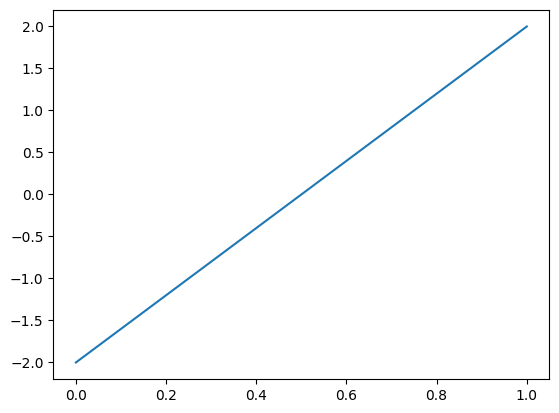

In [3]:
plt.plot(xp,fun_x)
plt.show()

In [4]:
#print(fun_x)

In [5]:
# generate a 1D mesh
ngmesh = NGMesh()
ngmesh.dim = 1

# Bem. stiw: wir brauchen etwas mehr Elemente als nur eines
nel = 100
l0 = 2

pnums = []
for i in range(0, nel+1):
    pnums.append (ngmesh.Add(MeshPoint (Pnt(i/nel*l0, 0, 0))))

for i in range(0,nel):
    ngmesh.Add (Element1D([pnums[i],pnums[i+1]], index=1))

ngmesh.Add (Element0D(pnums[0], index=1))
ngmesh.Add (Element0D(pnums[nel], index=2))

mesh = Mesh(ngmesh)

In [6]:
# Startwerte:
t0 = 0
dt0 = 0.1
tend = 5
eps0 = 1e-3
d2t = 0.05  #Änderungsrate für dt

# Initialisierung der Parameter
t = Parameter (t0)
dt = Parameter (dt0)
eps = Parameter (eps0)

In [7]:
order = 2
# Bem. stiw: keine Dirichlet Randwerte
V = H1(mesh, order=order)#, dirichlet=[1,2])
u = V.TrialFunction()
v = V.TestFunction()
gfu = GridFunction(V)

a = BilinearForm (V, symmetric = False)
a += Variation((eps/2*grad(u)*grad(u) 
               +(u**2*(1-u*u)**2)
               + 0.5/dt*(u-gfu)**2)*dx)

# Interpolate the function onto the finite element space
# Bem. stiw: hier können wir die Koordinaten CF benutzen
u0 = GridFunction(V)
u0.Set(-2+4*x)
#oder
u0.Set(fun(x))

# Set the initial condition on the GridFunction
gfu.Set(-2+4*x)

In [8]:
res = gfu.vec.CreateVector()
du = gfu.vec.CreateVector()

# Newton Verfahren:
start_time = time.time()
for it in range(20):
    print("Newton iteration", it)

    # lösen des linearisierten Problems:
    # F(u_n)
    a.Apply (gfu.vec, res)

    # F'(u_n)
    a.AssembleLinearization(gfu.vec)

    #du.vec.data = a.mat.Inverse(V.FreeDofs(), inverse="umfpack") * res.vec
    #du.vec.data= a * res
    du.data = a.mat.Inverse(V.FreeDofs(), inverse="umfpack") * res

    # update gfu
    # u_n+1 = u_n - du
    gfu.vec.data -= du

    # eps für nächsten Zeitschritt updaten
    eps.Set(eps.Get() * 1e-2)
    print("eps:", eps.Get())

    # Aktuelle Zeit updaten
    t.Set(t.Get()+dt.Get())
    print("Seconds passed: ", t.Get())

    # Abbruchkriterium: nach 2 Sekunden (wie in Aufgabenstellung beschrieben)
    t += dt.Get()
    print(t)
    if t >= tend:
        break

    # dt für nächsten Schritt updaten
    dt.Set(dt.Get() + d2t)
    print("dt für nächste Iteration: ", dt.Get())

    # Abbruchkriterium: wenn es vor schon vor Ablauf der 2 Sekunden konvergiert
    stopcritval = sqrt(abs(InnerProduct(du,res)))
    print ("<A u",it,", A u",it,">_{-1}A0.S = ", stopcritval)
    print(gfu)
    if stopcritval < 1e-13:
        break

end_time = time.time()
time_to_compute = end_time - start_time

Newton iteration 0
eps: 1e-05
Seconds passed:  0.1
ParameterCF, val = 0.2

dt für nächste Iteration:  0.15000000000000002
<A u 0 , A u 0 >_{-1}A0.S =  105.55193547108746
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 1
eps: 1.0000000000000001e-07
Seconds passed:  0.35000000000000003
ParameterCF, val = 0.5

dt für nächste Iteration:  0.2
<A u 1 , A u 1 >_{-1}A0.S =  53.785237912599506
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 2
eps: 1e-09
Seconds passed:  0.7
ParameterCF, val = 0.9

dt für nächste Iteration:  0.25
<A u 2 , A u 2 >_{-1}A0.S =  27.328469309449126
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 3
eps: 1.0000000000000001e-11
Seconds passed:  1.15
ParameterCF, val = 1.4

dt für nächste Iteration:  0.3
<A u 3 , A u 3 >_{-1}A0.S =  13.822596719270534
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
auto

In [9]:
# Bem. stiw: bringt in 1d nichts.
Draw(gfu)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

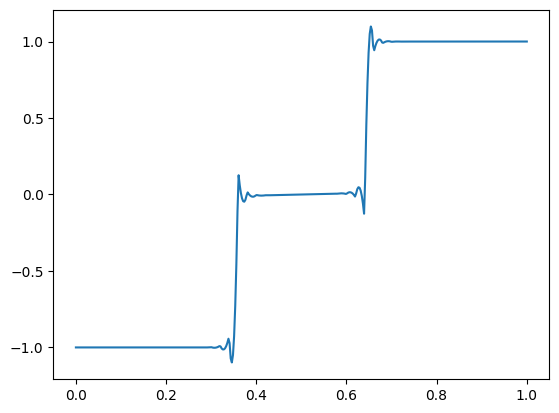

In [10]:
# Bem. stiw: Visualisierung
plt.plot(xp,gfu(mesh(xp)).flatten())